In [30]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
from sklearn.model_selection import GridSearchCV
import pprint

import seaborn as sns

In [2]:
df = pd.read_csv('rt_2563789698568873_abrupto.csv')
df

,X1,X2,class
0,0.362671,0.667272,1.0
1,0.366724,0.831947,1.0
2,0.167760,0.234370,1.0
3,0.054344,0.891496,1.0
4,0.639298,0.010638,0.0
...,...,...,...
39995,0.579554,0.589774,0.0
39996,0.897558,0.961799,1.0
39997,0.570111,0.169098,0.0
39998,0.609117,0.765140,1.0


In [3]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        st = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    st.columns = cols
    print('___________________________\nData Types:')
    print(st.Types.value_counts())
    print('___________________________')
    return st

In [22]:

X_on_pre = df.iloc[:10001,:2]
y_on_pre = df.iloc[:10001,-1]

X_hold_pre = df.iloc[30001:37001,:2]
y_hold_pre = df.iloc[30001:37001,-1]
X_hold_pre_test = df.iloc[37001:,:2]
y_hold_pre_test = df.iloc[37001:,-1]


X_on = df.iloc[:,:2]
y_on = df.iloc[:,-1]

X_hold = df.iloc[:37001,:2]
y_hold = df.iloc[:37001,-1]
X_hold_test = df.iloc[37001:,:2]
y_hold_test = df.iloc[37001:,-1]

In [31]:
# Concept Drift 이전의 데이터 hold out

sc = SGDClassifier(loss='log')
sc.fit(X_hold_pre,y_hold_pre)
print('train score: ',sc.score(X_hold_pre,y_hold_pre))
print('test score: ',sc.score(X_hold_pre_test,y_hold_pre_test))
print(classification_report(y_hold_pre_test,sc.predict(X_hold_pre_test)))
print(f1_score(y_hold_pre_test,sc.predict(X_hold_pre_test)))

train score:  0.6925714285714286
test score:  0.6992330776925642
              precision    recall  f1-score   support

         0.0       0.65      0.88      0.75      1548
         1.0       0.80      0.50      0.62      1451

    accuracy                           0.70      2999
   macro avg       0.73      0.69      0.69      2999
weighted avg       0.73      0.70      0.69      2999

0.6181202370872143


In [33]:
# hyper parameter tuning with grid search
params = {"alpha":[0.005,0.01,0.05,0.1]}
sc_t = SGDClassifier(loss='log',n_jobs=-1)

grid_sc = GridSearchCV(sc_t,param_grid=params,cv = 5)
grid_sc.fit(X_hold_pre,y_hold_pre)
print('best parameters : ', grid_sc.best_params_)
print('best score : ', grid_sc.best_score_)
print('test score : ', grid_sc.best_estimator_.score(X_hold_pre_test,y_hold_pre_test))
print(classification_report(y_hold_pre_test,grid_sc.best_estimator_.predict(X_hold_pre_test)))
print(f1_score(y_hold_pre_test,grid_sc.best_estimator_.predict(X_hold_pre_test)))


best parameters :  {'alpha': 0.1}
best score :  0.6922857142857144
test score :  0.6938979659886629
              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73      1548
         1.0       0.74      0.57      0.64      1451

    accuracy                           0.69      2999
   macro avg       0.70      0.69      0.69      2999
weighted avg       0.70      0.69      0.69      2999

0.6425233644859814


In [34]:
# Concept Drift 포함 모든 데이터 hold out 

sc = SGDClassifier(loss='log')
sc.fit(X_hold,y_hold)
print('train score: ',sc.score(X_hold,y_hold))
print('test score: ',sc.score(X_hold_test,y_hold_test))
print(classification_report(y_hold_test,sc.predict(X_hold_test)))
print(f1_score(y_hold_test,sc.predict(X_hold_test)))



train score:  0.6535228777600606
test score:  0.5985328442814272
              precision    recall  f1-score   support

         0.0       0.59      0.71      0.65      1548
         1.0       0.61      0.48      0.54      1451

    accuracy                           0.60      2999
   macro avg       0.60      0.59      0.59      2999
weighted avg       0.60      0.60      0.59      2999

0.5376344086021505


In [20]:
# hyper parameter tuning with grid search
params = {"alpha":[0.005,0.01,0.05,0.1]}
sc_t = SGDClassifier(loss='log',n_jobs=-1)

grid_sc = GridSearchCV(sc_t,param_grid=params,cv = 5)
grid_sc.fit(X_hold,y_hold)
print('best parameters : ', grid_sc.best_params_)
print('best score : ', grid_sc.best_score_)
print('test score : ', grid_sc.best_estimator_.score(X_hold_test,y_hold_test))
print(classification_report(y_hold_test,grid_sc.best_estimator_.predict(X_hold_test)))


best parameters :  {'alpha': 0.01}
best score :  0.642843512746634
test score :  0.6055351783927976
              precision    recall  f1-score   support

         0.0       0.61      0.66      0.63      1548
         1.0       0.60      0.55      0.58      1451

    accuracy                           0.61      2999
   macro avg       0.61      0.60      0.60      2999
weighted avg       0.61      0.61      0.60      2999



In [28]:
# Concept Drift 포함 모든 데이터 online learning
sc_on = SGDClassifier(loss='log')
y_tmp =y_on_pre.to_numpy().reshape(-1,1)
y_hat = []
c = np.unique(y_on_pre)
for i in range(len(X_on_pre)-1):
    sc_on.partial_fit(X_on_pre.iloc[i,:].to_numpy().reshape(1,-1),y_tmp[i],classes=c)
    x_1 = X_on_pre.iloc[i+1,:].to_numpy().reshape(1,-1)
    y_hat.append(sc_on.predict(x_1)[0])
print('score: ',accuracy_score(y_on_pre[1:],y_hat))
print(classification_report(y_on_pre[1:],y_hat))


score:  0.6881
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      5039
         1.0       0.68      0.69      0.69      4961

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



In [29]:
# Concept Drift 포함 모든 데이터 online learning
sc_on = SGDClassifier(loss='log')
y_tmp =y_on.to_numpy().reshape(-1,1)
y_hat = []
c = np.unique(y_on)
for i in range(len(X_on)-1):
    sc_on.partial_fit(X_on.iloc[i,:].to_numpy().reshape(1,-1),y_tmp[i],classes=c)
    x_1 = X_on.iloc[i+1,:].to_numpy().reshape(1,-1)
    y_hat.append(sc_on.predict(x_1)[0])
print('score: ',accuracy_score(y_on[1:],y_hat))
print(classification_report(y_on[1:],y_hat))


score:  0.6992674816870422
              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72     20577
         1.0       0.70      0.66      0.68     19422

    accuracy                           0.70     39999
   macro avg       0.70      0.70      0.70     39999
weighted avg       0.70      0.70      0.70     39999



In [ ]:
sc_on.pre

In [ ]:
# Concept Drift 이전의 데이터 online learning

sc_on = SGDClassifier(loss='log')
y_tmp =y.to_numpy().reshape(-1,1)
c = np.unique(y)
for i in range(len(X)):

    sc_on.partial_fit(X.iloc[i,:].to_numpy().reshape(1,-1),y_tmp[i],classes=c)


sc_on.score(X_pre,y_pre)

In [24]:
df.iloc[:10000,:].mean()

X1       0.50031
X2       0.49936
class    0.48910
dtype: float64

<AxesSubplot:>

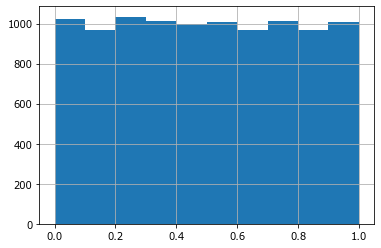

In [26]:
df.iloc[10000:20000,0].hist()


In [20]:
df = pd.read_csv('rt_2563789698568873_gradual.csv')


<AxesSubplot:>

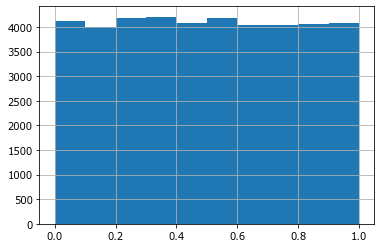

In [22]:
df.iloc[:,0].hist()